In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import *
from tqdm import tqdm
from utils import LoadRumoursDataset
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pylab as plt
import uuid
from tqdm import tqdm
import seaborn as sns

In [3]:
mlflow.end_run()

In [15]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("GradientBoosting 2024-08-24")

2024/08/24 18:48:42 INFO mlflow.tracking.fluent: Experiment with name 'GradientBoosting 2024-08-24' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/7', creation_time=1724525322493, experiment_id='7', last_update_time=1724525322493, lifecycle_stage='active', name='GradientBoosting 2024-08-24', tags={}>

In [2]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"


In [3]:
time_cut =5
processor = LoadRumoursDataset(file_path_replies, file_path_posts, time_cut)
processor.load_data()
processor.process_data()
df_final = processor.get_final_dataframe()
df_final['id'] = [uuid.uuid4() for _ in range(len(df_final))]


In [8]:
df_final.groupby('rumour')['id'].count()

rumour
0    1555
1     447
Name: id, dtype: int64

In [35]:
df_not_rumours = df_final[df_final.rumour==0]

n = int((df_final.rumour.sum())*1) // df_not_rumours['replies'].nunique()  # Unique number of values in 'replies' column

# Group by 'replies' and sample 'n' rows from each group
subset_df_not_rumours= df_not_rumours.sample(n= df_final[df_final.rumour==1].shape[0])

#subset_df_not_rumours= df_not_rumours.groupby('replies',group_keys=False).apply(lambda x: x.sample(n=min(len(x), n))).reset_index(drop=True)


In [38]:
df_final_balanced =pd.concat([subset_df_not_rumours,df_final[df_final.rumour==1]])

In [39]:
df_final_remaining = df_final[(~df_final.id.isin(subset_df_not_rumours.id))&(df_final.rumour==0)]

In [40]:
X  = df_final_balanced.drop(columns=['rumour','id'])
X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
y =df_final_balanced['rumour']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42,stratify=y,shuffle=True
)

In [41]:
X_test_all  = df_final_remaining.drop(columns=['rumour','id'])
X_test_all = np.hstack([X_test_all.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X_test_all.embeddings_avg.tolist()))])
y_test_all =df_final_remaining['rumour']
X_test_all = np.concatenate((X_test_all, X_test), axis=0)
y_test_all = pd.concat([y_test_all, y_test], axis=0)

In [42]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    # Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]

    # Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    # Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='recall')
    
    # Print model report for Train:
    print("\nModel Report Train")
    print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
    print("Recall : %f" % recall_score(y_train, dtrain_predictions))
    
    # Plot confusion matrix for Train
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_train, dtrain_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Train")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    # Print model report for Test:
    print("\nModel Report Test")
    print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
    print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
    print("Recall : %f" % recall_score(y_test, dtest_predictions))
    
    # Plot confusion matrix for Test
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, dtest_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Test")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.tight_layout()
    plt.show()
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    return alg




Model Report Train
AUC Score : 0.999990
Accuracy : 0.9968
Precision : 0.9968
Recall : 0.996805

Model Report Test
AUC Score : 0.888281
Accuracy : 0.8327
Precision : 0.8027
Recall : 0.880597


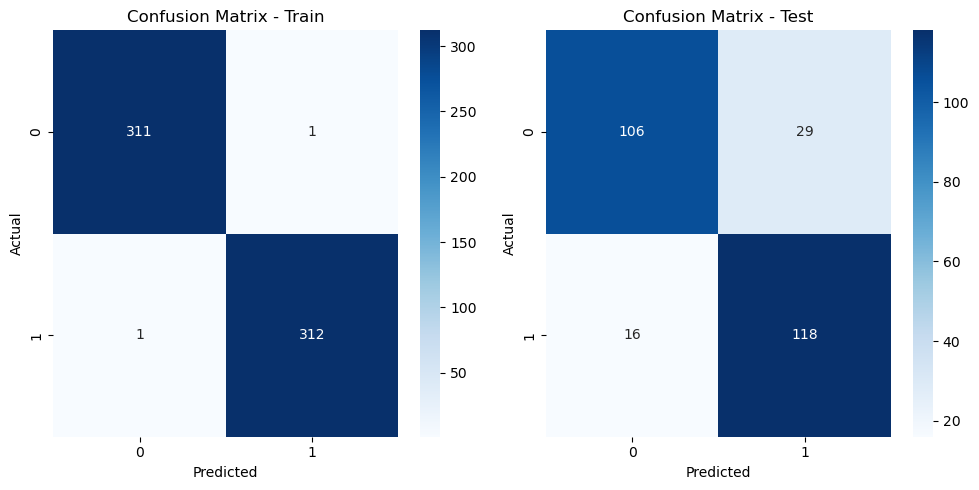

CV Score : Mean - 0.8435228 | Std - 0.05782693 | Min - 0.7619048 | Max - 0.9365079


GradientBoostingClassifier(random_state=42)

In [43]:
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=42)
modelfit(gbm0, X_train, y_train,X_test,y_test)

In [54]:
#Choose all predictors except target & IDcols
param_test1 = {'n_estimators':range(5,100,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, min_samples_split=5,
                                  min_samples_leaf=10,max_depth=5,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='recall',n_jobs=2, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  max_depth=5,
                                                  max_features='sqrt',
                                                  min_samples_leaf=10,
                                                  min_samples_split=5,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=2, param_grid={'n_estimators': range(5, 100, 5)},
             scoring='recall')

In [55]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 75}, 0.8530977982590885)

In [56]:

#Grid seach on subsample and max_features
param_test2 = {'max_depth':range(3,15,3), 'min_samples_split':range(2,20,5)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=75,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='recall',n_jobs=2, cv=5)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  max_features='sqrt',
                                                  n_estimators=75,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=2,
             param_grid={'max_depth': range(3, 15, 3),
                         'min_samples_split': range(2, 20, 5)},
             scoring='recall')

In [57]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 9, 'min_samples_split': 12}, 0.8625704045058884)

In [58]:
#Grid seach on subsample and max_features
param_test3 = { 'min_samples_split':range(2,20,5), 'min_samples_leaf':range(2,20,3)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=75,max_depth=9,
                                                    max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='recall',n_jobs=2, cv=5)
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  max_depth=9,
                                                  max_features='sqrt',
                                                  n_estimators=75,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=2,
             param_grid={'min_samples_leaf': range(2, 20, 3),
                         'min_samples_split': range(2, 20, 5)},
             scoring='recall')

In [59]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 2, 'min_samples_split': 12}, 0.869073220686124)

In [60]:
#Grid seach on subsample and max_features
param_test4 = {'max_features':range(4,80,5)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=75,max_depth=9, 
                            min_samples_split=12, min_samples_leaf=2, random_state=10),
                       param_grid = param_test4, scoring='recall',n_jobs=2, cv=5)
gsearch4.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  max_depth=9,
                                                  min_samples_leaf=2,
                                                  min_samples_split=12,
                                                  n_estimators=75,
                                                  random_state=10),
             n_jobs=2, param_grid={'max_features': range(4, 80, 5)},
             scoring='recall')

In [61]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 39}, 0.8658986175115209)

In [62]:
#Grid seach on subsample and max_features
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=75,max_depth=9, 
                            min_samples_split=12, min_samples_leaf=2, random_state=10, max_features=39),
                       param_grid = param_test5, scoring='recall',n_jobs=2, cv=5)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  max_depth=9, max_features=39,
                                                  min_samples_leaf=2,
                                                  min_samples_split=12,
                                                  n_estimators=75,
                                                  random_state=10),
             n_jobs=2,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
             scoring='recall')

In [63]:
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.6}, 0.8626216077828982)


Model Report Train
AUC Score : 0.999314
Accuracy : 0.984
Precision : 0.9779
Recall : 0.990415

Model Report Test
AUC Score : 0.915206
Accuracy : 0.8301
Precision : 0.3529
Recall : 0.895522


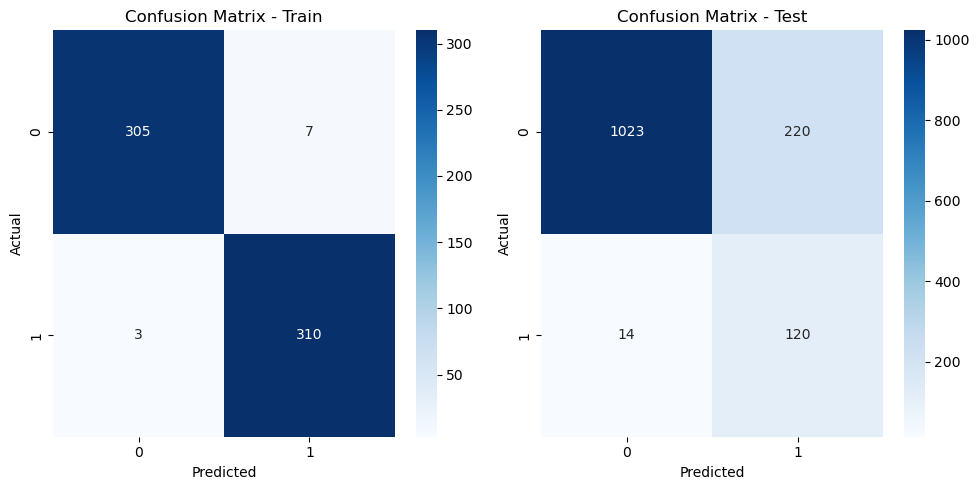

CV Score : Mean - 0.8402458 | Std - 0.04713845 | Min - 0.7619048 | Max - 0.9047619


In [67]:
#Choose all predictors except target & IDcols
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=15,max_depth=12,
                            min_samples_split=12, min_samples_leaf=5, random_state=10, max_features=59,subsample=0.8)

model = modelfit(gbm_tuned_1,  X_train, y_train,X_test_all,y_test_all)


Model Report Train
AUC Score : 0.927163
Accuracy : 0.8592
Precision : 0.8527
Recall : 0.869010

Model Report Test
AUC Score : 0.869762
Accuracy : 0.7881
Precision : 0.7584
Recall : 0.843284


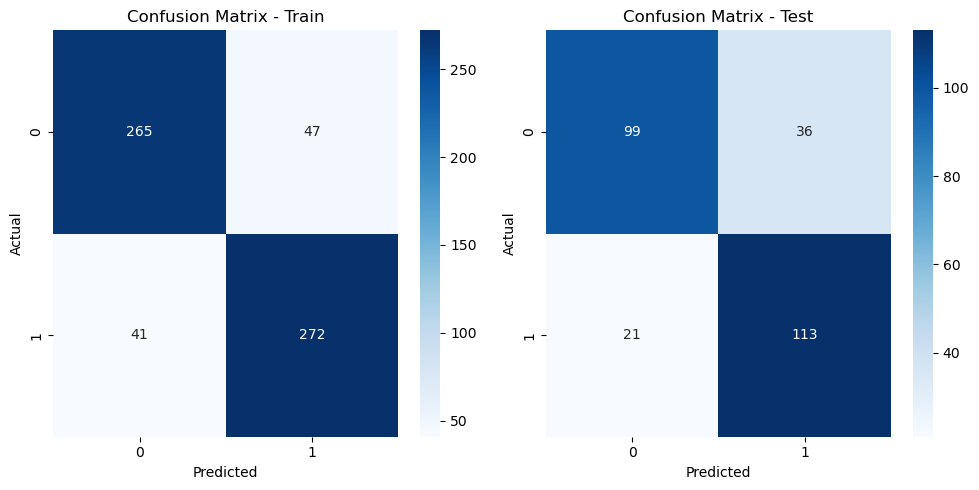

CV Score : Mean - 0.8274962 | Std - 0.05534087 | Min - 0.7301587 | Max - 0.8888889


GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=12,
                           n_estimators=15, subsample=0.8)

In [68]:
#Choose all predictors except target & IDcols
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=15,min_samples_split=12,min_samples_leaf=5,\
                                         subsample=0.8,max_features='sqrt')
modelfit(gbm_tuned_1,  X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 0.936128
Accuracy : 0.8528
Precision : 0.8359
Recall : 0.878594

Model Report Test
AUC Score : 0.892430
Accuracy : 0.7901
Precision : 0.3048
Recall : 0.902985


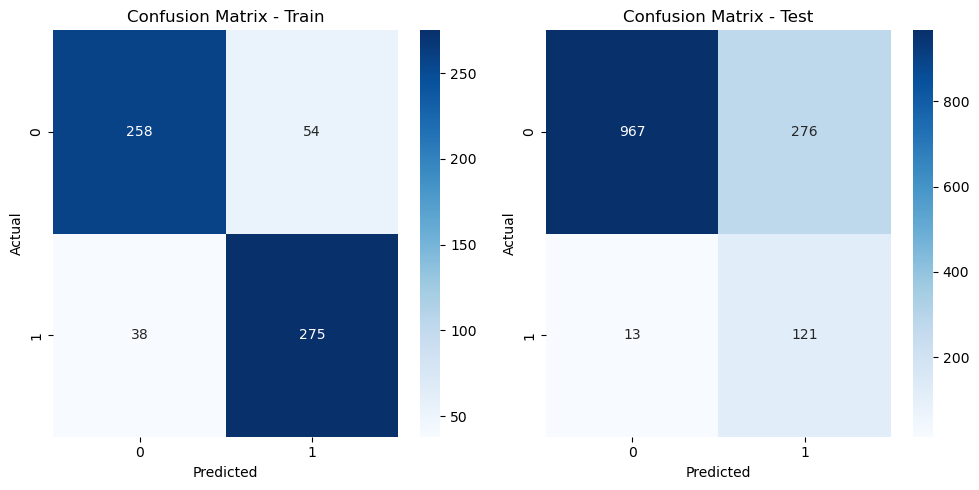

CV Score : Mean - 0.827445 | Std - 0.04320537 | Min - 0.7777778 | Max - 0.9047619


GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=12,
                           n_estimators=15, subsample=0.8)

In [71]:
#Choose all predictors except target & IDcols
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=15,min_samples_split=12,min_samples_leaf=5,\
                                         subsample=0.8,max_features='sqrt')
modelfit(gbm_tuned_1,  X_train, y_train,X_test_all,y_test_all)

In [113]:
mlflow.end_run()

In [18]:
def modelfit(alg, X_train, y_train, X_test, y_test, printFeatureImportance=True):
    with mlflow.start_run():
        # Fit the algorithm on the data
        alg.fit(X_train, y_train)
            
        # Predict training set:
        dtrain_predictions = alg.predict(X_train)
        dtrain_predprob = alg.predict_proba(X_train)[:, 1]

        # Predict test set:
        dtest_predictions = alg.predict(X_test)
        dtest_predprob = alg.predict_proba(X_test)[:, 1]

        # Log model parameters
        mlflow.log_params(alg.get_params())

        # Log metrics for Train
        mlflow.log_metric("train_auc", roc_auc_score(y_train, dtrain_predprob))
        mlflow.log_metric("train_accuracy", accuracy_score(y_train, dtrain_predictions))
        mlflow.log_metric("train_precision", precision_score(y_train, dtrain_predictions))
        mlflow.log_metric("train_recall", recall_score(y_train, dtrain_predictions))

        # Log metrics for Test
        mlflow.log_metric("test_auc", roc_auc_score(y_test, dtest_predprob))
        mlflow.log_metric("test_accuracy", accuracy_score(y_test, dtest_predictions))
        mlflow.log_metric("test_precision", precision_score(y_test, dtest_predictions))
        mlflow.log_metric("test_recall", recall_score(y_test, dtest_predictions))

        # Print model report for Train
        print("\nModel Report Train")
        print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
        print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
        print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
        print("Recall : %f" % recall_score(y_train, dtrain_predictions))

        # Plot confusion matrix for Train
        
        #plt.figure(figsize=(10, 5))
        #plt.subplot(1, 2, 1)
        #sns.heatmap(confusion_matrix(y_train, dtrain_predictions), annot=True, fmt="d", cmap="Blues")
        #plt.title("Confusion Matrix - Train")
        #plt.xlabel("Predicted")
        #plt.ylabel("Actual")

        # Log confusion matrix for Train
        train_cm = confusion_matrix(y_train, dtrain_predictions)
        mlflow.log_artifact(plot_confusion_matrix(train_cm, "Train"))

        # Print model report for Test
        print("\nModel Report Test")
        print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
        print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
        print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
        print("Recall : %f" % recall_score(y_test, dtest_predictions))

        # Plot confusion matrix for Test
        #plt.subplot(1, 2, 2)
        #sns.heatmap(confusion_matrix(y_test, dtest_predictions), annot=True, fmt="d", cmap="Blues")
        #plt.title("Confusion Matrix - Test")
        #plt.xlabel("Predicted")
        #plt.ylabel("Actual")

        # Log confusion matrix for Test
        test_cm = confusion_matrix(y_test, dtest_predictions)
        mlflow.log_artifact(plot_confusion_matrix(test_cm, "Test"))

        plt.tight_layout()
        plt.show()

        # Log the model with input example
        input_example = X_train[0:1]   # Use the first row of X_train as an example
        mlflow.sklearn.log_model(alg, "model", input_example=input_example)
        mlflow.log_metric("time_cut", time_cut)
    
    # Explicitly end the MLflow run
    mlflow.end_run()

    return alg

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"confusion_matrix_{title}.png")
    plt.close()
    return f"confusion_matrix_{title}.png"

In [19]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(5,48*60,15):
    print(time_cut)
    processor = LoadRumoursDataset(file_path_replies, file_path_posts, time_cut)
    processor.load_data()
    processor.process_data()
    df_final = processor.get_final_dataframe()
    df_final['id'] = [uuid.uuid4() for _ in range(len(df_final))]
    df_not_rumours = df_final[df_final.rumour==0]

    n =  df_final[df_final.rumour==1].shape[0]  # Unique number of values in 'replies' column

    # Group by 'replies' and sample 'n' rows from each group
    subset_df_not_rumours= df_not_rumours.sample(n= n)
    df_final_balanced =pd.concat([subset_df_not_rumours,df_final[df_final.rumour==1]])
    df_final_remaining = df_final[(~df_final.id.isin(subset_df_not_rumours.id))&(df_final.rumour==0)]

    X  = df_final_balanced.drop(columns=['rumour','id'])
    X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
    y =df_final_balanced['rumour']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42,stratify=y,shuffle=True
    )

    X_test_all  = df_final_remaining.drop(columns=['rumour','id'])
    X_test_all = np.hstack([X_test_all.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X_test_all.embeddings_avg.tolist()))])
    y_test_all =df_final_remaining['rumour']
    X_test_all = np.concatenate((X_test_all, X_test), axis=0)
    y_test_all = pd.concat([y_test_all, y_test], axis=0)
    
    gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=15,min_samples_split=12,min_samples_leaf=5,\
                                         subsample=0.8,max_features='sqrt')
    
    modelfit(gbm_tuned_1,  X_train, y_train,X_test_all,y_test_all)

5

Model Report Train
AUC Score : 0.930367
Accuracy : 0.8587
Precision : 0.8391
Recall : 0.888268

Model Report Test
AUC Score : 0.895439
Accuracy : 0.8127
Precision : 0.245
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

20

Model Report Train
AUC Score : 0.935594
Accuracy : 0.8601
Precision : 0.8564
Recall : 0.865922

Model Report Test
AUC Score : 0.887673
Accuracy : 0.7941
Precision : 0.2381
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

35

Model Report Train
AUC Score : 0.920868
Accuracy : 0.8364
Precision : 0.8051
Recall : 0.888268

Model Report Test
AUC Score : 0.908232
Accuracy : 0.8205
Precision : 0.2601
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

50

Model Report Train
AUC Score : 0.930825
Accuracy : 0.8629
Precision : 0.8351
Recall : 0.905028

Model Report Test
AUC Score : 0.896293
Accuracy : 0.777
Precision : 0.2219
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

65

Model Report Train
AUC Score : 0.940625
Accuracy : 0.8713
Precision : 0.8736
Recall : 0.868715

Model Report Test
AUC Score : 0.889338
Accuracy : 0.8057
Precision : 0.2444
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

80

Model Report Train
AUC Score : 0.936278
Accuracy : 0.8601
Precision : 0.8468
Recall : 0.879888

Model Report Test
AUC Score : 0.892883
Accuracy : 0.7995
Precision : 0.2334
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

95

Model Report Train
AUC Score : 0.936501
Accuracy : 0.8643
Precision : 0.8304
Recall : 0.916201

Model Report Test
AUC Score : 0.887734
Accuracy : 0.7778
Precision : 0.2111
Recall : 0.808989


<Figure size 640x480 with 0 Axes>

110

Model Report Train
AUC Score : 0.929878
Accuracy : 0.8629
Precision : 0.8476
Recall : 0.885475

Model Report Test
AUC Score : 0.881591
Accuracy : 0.7809
Precision : 0.2187
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

125

Model Report Train
AUC Score : 0.931212
Accuracy : 0.8699
Precision : 0.8496
Recall : 0.899441

Model Report Test
AUC Score : 0.892991
Accuracy : 0.8003
Precision : 0.2391
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

140

Model Report Train
AUC Score : 0.938544
Accuracy : 0.8643
Precision : 0.8425
Recall : 0.896648

Model Report Test
AUC Score : 0.882867
Accuracy : 0.7879
Precision : 0.2246
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

155

Model Report Train
AUC Score : 0.916405
Accuracy : 0.8392
Precision : 0.8275
Recall : 0.857542

Model Report Test
AUC Score : 0.889483
Accuracy : 0.7988
Precision : 0.2344
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

170

Model Report Train
AUC Score : 0.926017
Accuracy : 0.8476
Precision : 0.8268
Recall : 0.879888

Model Report Test
AUC Score : 0.887486
Accuracy : 0.7762
Precision : 0.2197
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

185

Model Report Train
AUC Score : 0.936267
Accuracy : 0.8685
Precision : 0.8607
Recall : 0.879888

Model Report Test
AUC Score : 0.883922
Accuracy : 0.7778
Precision : 0.2178
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

200

Model Report Train
AUC Score : 0.936024
Accuracy : 0.8629
Precision : 0.8591
Recall : 0.868715

Model Report Test
AUC Score : 0.888203
Accuracy : 0.7972
Precision : 0.2362
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

215

Model Report Train
AUC Score : 0.932617
Accuracy : 0.8476
Precision : 0.8268
Recall : 0.879888

Model Report Test
AUC Score : 0.890337
Accuracy : 0.8019
Precision : 0.2406
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

230

Model Report Train
AUC Score : 0.937229
Accuracy : 0.8587
Precision : 0.856
Recall : 0.863128

Model Report Test
AUC Score : 0.885202
Accuracy : 0.7739
Precision : 0.2131
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

245

Model Report Train
AUC Score : 0.924561
Accuracy : 0.8336
Precision : 0.8104
Recall : 0.871508

Model Report Test
AUC Score : 0.898966
Accuracy : 0.8127
Precision : 0.2516
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

260

Model Report Train
AUC Score : 0.942518
Accuracy : 0.8643
Precision : 0.8595
Recall : 0.871508

Model Report Test
AUC Score : 0.875893
Accuracy : 0.7708
Precision : 0.2107
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

275

Model Report Train
AUC Score : 0.928309
Accuracy : 0.8559
Precision : 0.8329
Recall : 0.891061

Model Report Test
AUC Score : 0.904762
Accuracy : 0.8019
Precision : 0.2438
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

290

Model Report Train
AUC Score : 0.929381
Accuracy : 0.8559
Precision : 0.8455
Recall : 0.871508

Model Report Test
AUC Score : 0.900321
Accuracy : 0.7918
Precision : 0.236
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

305

Model Report Train
AUC Score : 0.926502
Accuracy : 0.8601
Precision : 0.8413
Recall : 0.888268

Model Report Test
AUC Score : 0.892377
Accuracy : 0.8011
Precision : 0.2349
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

320

Model Report Train
AUC Score : 0.934009
Accuracy : 0.8643
Precision : 0.8595
Recall : 0.871508

Model Report Test
AUC Score : 0.895753
Accuracy : 0.7832
Precision : 0.2254
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

335

Model Report Train
AUC Score : 0.926627
Accuracy : 0.8531
Precision : 0.8447
Recall : 0.865922

Model Report Test
AUC Score : 0.877999
Accuracy : 0.7801
Precision : 0.2164
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

350

Model Report Train
AUC Score : 0.928274
Accuracy : 0.842
Precision : 0.8232
Recall : 0.871508

Model Report Test
AUC Score : 0.889338
Accuracy : 0.7778
Precision : 0.221
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

365

Model Report Train
AUC Score : 0.933113
Accuracy : 0.8601
Precision : 0.8468
Recall : 0.879888

Model Report Test
AUC Score : 0.886215
Accuracy : 0.7739
Precision : 0.2163
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

380

Model Report Train
AUC Score : 0.924362
Accuracy : 0.849
Precision : 0.8289
Recall : 0.879888

Model Report Test
AUC Score : 0.897132
Accuracy : 0.777
Precision : 0.2188
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

395

Model Report Train
AUC Score : 0.936975
Accuracy : 0.8615
Precision : 0.8472
Recall : 0.882682

Model Report Test
AUC Score : 0.891270
Accuracy : 0.7653
Precision : 0.2098
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

410

Model Report Train
AUC Score : 0.938438
Accuracy : 0.8671
Precision : 0.8623
Recall : 0.874302

Model Report Test
AUC Score : 0.897995
Accuracy : 0.7956
Precision : 0.2364
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

425

Model Report Train
AUC Score : 0.942953
Accuracy : 0.8517
Precision : 0.8247
Recall : 0.893855

Model Report Test
AUC Score : 0.885915
Accuracy : 0.7747
Precision : 0.2201
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

440

Model Report Train
AUC Score : 0.925234
Accuracy : 0.8573
Precision : 0.8282
Recall : 0.902235

Model Report Test
AUC Score : 0.888447
Accuracy : 0.8026
Precision : 0.2477
Recall : 0.910112


<Figure size 640x480 with 0 Axes>

455

Model Report Train
AUC Score : 0.929127
Accuracy : 0.8517
Precision : 0.8387
Recall : 0.871508

Model Report Test
AUC Score : 0.892353
Accuracy : 0.8011
Precision : 0.2399
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

470

Model Report Train
AUC Score : 0.937511
Accuracy : 0.8503
Precision : 0.826
Recall : 0.888268

Model Report Test
AUC Score : 0.897348
Accuracy : 0.8042
Precision : 0.2413
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

485

Model Report Train
AUC Score : 0.931658
Accuracy : 0.8559
Precision : 0.8382
Recall : 0.882682

Model Report Test
AUC Score : 0.882749
Accuracy : 0.7887
Precision : 0.2252
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

500

Model Report Train
AUC Score : 0.928403
Accuracy : 0.8503
Precision : 0.8294
Recall : 0.882682

Model Report Test
AUC Score : 0.899355
Accuracy : 0.7902
Precision : 0.233
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

515

Model Report Train
AUC Score : 0.937049
Accuracy : 0.8699
Precision : 0.8515
Recall : 0.896648

Model Report Test
AUC Score : 0.886651
Accuracy : 0.7848
Precision : 0.2186
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

530

Model Report Train
AUC Score : 0.941591
Accuracy : 0.8797
Precision : 0.8676
Recall : 0.896648

Model Report Test
AUC Score : 0.884320
Accuracy : 0.7793
Precision : 0.2206
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

545

Model Report Train
AUC Score : 0.935793
Accuracy : 0.8601
Precision : 0.8377
Recall : 0.893855

Model Report Test
AUC Score : 0.892532
Accuracy : 0.7832
Precision : 0.2173
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

560

Model Report Train
AUC Score : 0.935813
Accuracy : 0.8545
Precision : 0.836
Recall : 0.882682

Model Report Test
AUC Score : 0.893821
Accuracy : 0.7786
Precision : 0.22
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

575

Model Report Train
AUC Score : 0.927140
Accuracy : 0.835
Precision : 0.8125
Recall : 0.871508

Model Report Test
AUC Score : 0.887594
Accuracy : 0.805
Precision : 0.242
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

590

Model Report Train
AUC Score : 0.946970
Accuracy : 0.8769
Precision : 0.8729
Recall : 0.882682

Model Report Test
AUC Score : 0.891852
Accuracy : 0.7801
Precision : 0.2275
Recall : 0.910112


<Figure size 640x480 with 0 Axes>

605

Model Report Train
AUC Score : 0.927065
Accuracy : 0.8573
Precision : 0.8299
Recall : 0.899441

Model Report Test
AUC Score : 0.885732
Accuracy : 0.8065
Precision : 0.2403
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

620

Model Report Train
AUC Score : 0.929205
Accuracy : 0.8462
Precision : 0.8316
Recall : 0.868715

Model Report Test
AUC Score : 0.890900
Accuracy : 0.8026
Precision : 0.243
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

635

Model Report Train
AUC Score : 0.949322
Accuracy : 0.8699
Precision : 0.861
Recall : 0.882682

Model Report Test
AUC Score : 0.887514
Accuracy : 0.7747
Precision : 0.2153
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

650

Model Report Train
AUC Score : 0.928184
Accuracy : 0.8643
Precision : 0.839
Recall : 0.902235

Model Report Test
AUC Score : 0.891547
Accuracy : 0.7778
Precision : 0.2128
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

665

Model Report Train
AUC Score : 0.935825
Accuracy : 0.8573
Precision : 0.8368
Recall : 0.888268

Model Report Test
AUC Score : 0.889798
Accuracy : 0.7995
Precision : 0.2317
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

680

Model Report Train
AUC Score : 0.924409
Accuracy : 0.8462
Precision : 0.8163
Recall : 0.893855

Model Report Test
AUC Score : 0.887519
Accuracy : 0.8011
Precision : 0.2415
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

695

Model Report Train
AUC Score : 0.926658
Accuracy : 0.8545
Precision : 0.836
Recall : 0.882682

Model Report Test
AUC Score : 0.891917
Accuracy : 0.8019
Precision : 0.234
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

710

Model Report Train
AUC Score : 0.932519
Accuracy : 0.8657
Precision : 0.8484
Recall : 0.891061

Model Report Test
AUC Score : 0.893657
Accuracy : 0.7661
Precision : 0.212
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

725

Model Report Train
AUC Score : 0.940820
Accuracy : 0.8671
Precision : 0.8583
Recall : 0.879888

Model Report Test
AUC Score : 0.886412
Accuracy : 0.7887
Precision : 0.2252
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

740

Model Report Train
AUC Score : 0.927284
Accuracy : 0.8545
Precision : 0.824
Recall : 0.902235

Model Report Test
AUC Score : 0.895331
Accuracy : 0.7754
Precision : 0.2126
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

755

Model Report Train
AUC Score : 0.935246
Accuracy : 0.8601
Precision : 0.8505
Recall : 0.874302

Model Report Test
AUC Score : 0.885310
Accuracy : 0.7716
Precision : 0.2129
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

770

Model Report Train
AUC Score : 0.928638
Accuracy : 0.8559
Precision : 0.8382
Recall : 0.882682

Model Report Test
AUC Score : 0.896133
Accuracy : 0.805
Precision : 0.2437
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

785

Model Report Train
AUC Score : 0.928345
Accuracy : 0.8531
Precision : 0.8303
Recall : 0.888268

Model Report Test
AUC Score : 0.901474
Accuracy : 0.7995
Precision : 0.2334
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

800

Model Report Train
AUC Score : 0.944052
Accuracy : 0.8741
Precision : 0.8641
Recall : 0.888268

Model Report Test
AUC Score : 0.883054
Accuracy : 0.7848
Precision : 0.2251
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

815

Model Report Train
AUC Score : 0.927621
Accuracy : 0.8378
Precision : 0.827
Recall : 0.854749

Model Report Test
AUC Score : 0.892180
Accuracy : 0.8003
Precision : 0.2391
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

830

Model Report Train
AUC Score : 0.938692
Accuracy : 0.8643
Precision : 0.8518
Recall : 0.882682

Model Report Test
AUC Score : 0.887378
Accuracy : 0.784
Precision : 0.2245
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

845

Model Report Train
AUC Score : 0.929401
Accuracy : 0.8531
Precision : 0.8355
Recall : 0.879888

Model Report Test
AUC Score : 0.889605
Accuracy : 0.784
Precision : 0.2261
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

860

Model Report Train
AUC Score : 0.939377
Accuracy : 0.8629
Precision : 0.8591
Recall : 0.868715

Model Report Test
AUC Score : 0.880072
Accuracy : 0.7754
Precision : 0.2126
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

875

Model Report Train
AUC Score : 0.921213
Accuracy : 0.8531
Precision : 0.841
Recall : 0.871508

Model Report Test
AUC Score : 0.897906
Accuracy : 0.7956
Precision : 0.2364
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

890

Model Report Train
AUC Score : 0.931971
Accuracy : 0.842
Precision : 0.8165
Recall : 0.882682

Model Report Test
AUC Score : 0.877220
Accuracy : 0.784
Precision : 0.2212
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

905

Model Report Train
AUC Score : 0.941552
Accuracy : 0.8601
Precision : 0.8525
Recall : 0.871508

Model Report Test
AUC Score : 0.896283
Accuracy : 0.7964
Precision : 0.2387
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

920

Model Report Train
AUC Score : 0.933368
Accuracy : 0.8713
Precision : 0.8446
Recall : 0.910615

Model Report Test
AUC Score : 0.889296
Accuracy : 0.7902
Precision : 0.2299
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

935

Model Report Train
AUC Score : 0.921631
Accuracy : 0.842
Precision : 0.8198
Recall : 0.877095

Model Report Test
AUC Score : 0.889146
Accuracy : 0.7871
Precision : 0.2239
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

950

Model Report Train
AUC Score : 0.929855
Accuracy : 0.8643
Precision : 0.8518
Recall : 0.882682

Model Report Test
AUC Score : 0.891181
Accuracy : 0.7871
Precision : 0.2255
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

965

Model Report Train
AUC Score : 0.928947
Accuracy : 0.8476
Precision : 0.8234
Recall : 0.885475

Model Report Test
AUC Score : 0.891673
Accuracy : 0.7801
Precision : 0.2244
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

980

Model Report Train
AUC Score : 0.932961
Accuracy : 0.8517
Precision : 0.8462
Recall : 0.860335

Model Report Test
AUC Score : 0.884888
Accuracy : 0.7902
Precision : 0.2232
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

995

Model Report Train
AUC Score : 0.928603
Accuracy : 0.8559
Precision : 0.8329
Recall : 0.891061

Model Report Test
AUC Score : 0.884939
Accuracy : 0.7793
Precision : 0.219
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1010

Model Report Train
AUC Score : 0.931764
Accuracy : 0.8629
Precision : 0.8514
Recall : 0.879888

Model Report Test
AUC Score : 0.882806
Accuracy : 0.7941
Precision : 0.2333
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1025

Model Report Train
AUC Score : 0.929659
Accuracy : 0.8517
Precision : 0.8333
Recall : 0.879888

Model Report Test
AUC Score : 0.884508
Accuracy : 0.7786
Precision : 0.2232
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

1040

Model Report Train
AUC Score : 0.926690
Accuracy : 0.8517
Precision : 0.8387
Recall : 0.871508

Model Report Test
AUC Score : 0.896110
Accuracy : 0.7925
Precision : 0.2319
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1055

Model Report Train
AUC Score : 0.938516
Accuracy : 0.8741
Precision : 0.8622
Recall : 0.891061

Model Report Test
AUC Score : 0.873792
Accuracy : 0.7692
Precision : 0.2062
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

1070

Model Report Train
AUC Score : 0.932847
Accuracy : 0.8448
Precision : 0.8365
Recall : 0.857542

Model Report Test
AUC Score : 0.887504
Accuracy : 0.7964
Precision : 0.2338
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1085

Model Report Train
AUC Score : 0.929870
Accuracy : 0.8545
Precision : 0.8414
Recall : 0.874302

Model Report Test
AUC Score : 0.884686
Accuracy : 0.7832
Precision : 0.2222
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1100

Model Report Train
AUC Score : 0.923517
Accuracy : 0.8434
Precision : 0.8254
Recall : 0.871508

Model Report Test
AUC Score : 0.887096
Accuracy : 0.7988
Precision : 0.2377
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1115

Model Report Train
AUC Score : 0.922292
Accuracy : 0.8448
Precision : 0.8365
Recall : 0.857542

Model Report Test
AUC Score : 0.893141
Accuracy : 0.8151
Precision : 0.2508
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1130

Model Report Train
AUC Score : 0.924945
Accuracy : 0.8517
Precision : 0.8333
Recall : 0.879888

Model Report Test
AUC Score : 0.899735
Accuracy : 0.8034
Precision : 0.2437
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1145

Model Report Train
AUC Score : 0.929870
Accuracy : 0.8615
Precision : 0.8453
Recall : 0.885475

Model Report Test
AUC Score : 0.889624
Accuracy : 0.7863
Precision : 0.2312
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

1160

Model Report Train
AUC Score : 0.937421
Accuracy : 0.8657
Precision : 0.8541
Recall : 0.882682

Model Report Test
AUC Score : 0.880433
Accuracy : 0.7918
Precision : 0.2296
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1175

Model Report Train
AUC Score : 0.927202
Accuracy : 0.8615
Precision : 0.8509
Recall : 0.877095

Model Report Test
AUC Score : 0.892344
Accuracy : 0.7988
Precision : 0.236
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1190

Model Report Train
AUC Score : 0.928122
Accuracy : 0.8601
Precision : 0.8431
Recall : 0.885475

Model Report Test
AUC Score : 0.897629
Accuracy : 0.7972
Precision : 0.2378
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1205

Model Report Train
AUC Score : 0.934995
Accuracy : 0.8629
Precision : 0.8533
Recall : 0.877095

Model Report Test
AUC Score : 0.893554
Accuracy : 0.7793
Precision : 0.219
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1220

Model Report Train
AUC Score : 0.930453
Accuracy : 0.8685
Precision : 0.8626
Recall : 0.877095

Model Report Test
AUC Score : 0.884705
Accuracy : 0.7817
Precision : 0.216
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

1235

Model Report Train
AUC Score : 0.928701
Accuracy : 0.8559
Precision : 0.84
Recall : 0.879888

Model Report Test
AUC Score : 0.881333
Accuracy : 0.8034
Precision : 0.2405
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1250

Model Report Train
AUC Score : 0.929190
Accuracy : 0.842
Precision : 0.8338
Recall : 0.854749

Model Report Test
AUC Score : 0.886276
Accuracy : 0.8081
Precision : 0.2484
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1265

Model Report Train
AUC Score : 0.922871
Accuracy : 0.8322
Precision : 0.8115
Recall : 0.865922

Model Report Test
AUC Score : 0.889896
Accuracy : 0.7918
Precision : 0.2263
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1280

Model Report Train
AUC Score : 0.934471
Accuracy : 0.8531
Precision : 0.8391
Recall : 0.874302

Model Report Test
AUC Score : 0.892682
Accuracy : 0.7863
Precision : 0.2328
Recall : 0.910112


<Figure size 640x480 with 0 Axes>

1295

Model Report Train
AUC Score : 0.931991
Accuracy : 0.8531
Precision : 0.8373
Recall : 0.877095

Model Report Test
AUC Score : 0.906572
Accuracy : 0.7988
Precision : 0.2377
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1310

Model Report Train
AUC Score : 0.927257
Accuracy : 0.8434
Precision : 0.8289
Recall : 0.865922

Model Report Test
AUC Score : 0.886041
Accuracy : 0.8011
Precision : 0.2415
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1325

Model Report Train
AUC Score : 0.941439
Accuracy : 0.8685
Precision : 0.8492
Recall : 0.896648

Model Report Test
AUC Score : 0.893099
Accuracy : 0.7832
Precision : 0.2206
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1340

Model Report Train
AUC Score : 0.943770
Accuracy : 0.8601
Precision : 0.8395
Recall : 0.891061

Model Report Test
AUC Score : 0.889938
Accuracy : 0.7988
Precision : 0.2344
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1355

Model Report Train
AUC Score : 0.928153
Accuracy : 0.8392
Precision : 0.8156
Recall : 0.877095

Model Report Test
AUC Score : 0.889483
Accuracy : 0.7848
Precision : 0.2267
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1370

Model Report Train
AUC Score : 0.931118
Accuracy : 0.8615
Precision : 0.8548
Recall : 0.871508

Model Report Test
AUC Score : 0.903158
Accuracy : 0.8135
Precision : 0.2525
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1385

Model Report Train
AUC Score : 0.925708
Accuracy : 0.8462
Precision : 0.8246
Recall : 0.879888

Model Report Test
AUC Score : 0.888888
Accuracy : 0.7972
Precision : 0.2362
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1400

Model Report Train
AUC Score : 0.933501
Accuracy : 0.8713
Precision : 0.8575
Recall : 0.891061

Model Report Test
AUC Score : 0.882374
Accuracy : 0.77
Precision : 0.2085
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1415

Model Report Train
AUC Score : 0.929514
Accuracy : 0.8476
Precision : 0.8356
Recall : 0.865922

Model Report Test
AUC Score : 0.893033
Accuracy : 0.8042
Precision : 0.2445
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1430

Model Report Train
AUC Score : 0.928814
Accuracy : 0.842
Precision : 0.8267
Recall : 0.865922

Model Report Test
AUC Score : 0.902844
Accuracy : 0.7956
Precision : 0.2364
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1445

Model Report Train
AUC Score : 0.932922
Accuracy : 0.8573
Precision : 0.8478
Recall : 0.871508

Model Report Test
AUC Score : 0.888897
Accuracy : 0.7918
Precision : 0.2328
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1460

Model Report Train
AUC Score : 0.925583
Accuracy : 0.8462
Precision : 0.8316
Recall : 0.868715

Model Report Test
AUC Score : 0.891294
Accuracy : 0.8096
Precision : 0.2417
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

1475

Model Report Train
AUC Score : 0.932112
Accuracy : 0.8406
Precision : 0.8245
Recall : 0.865922

Model Report Test
AUC Score : 0.888799
Accuracy : 0.7995
Precision : 0.2317
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

1490

Model Report Train
AUC Score : 0.934745
Accuracy : 0.8657
Precision : 0.8503
Recall : 0.888268

Model Report Test
AUC Score : 0.891200
Accuracy : 0.7863
Precision : 0.2312
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

1505

Model Report Train
AUC Score : 0.947248
Accuracy : 0.8713
Precision : 0.8519
Recall : 0.899441

Model Report Test
AUC Score : 0.873563
Accuracy : 0.7622
Precision : 0.2091
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1520

Model Report Train
AUC Score : 0.915301
Accuracy : 0.8434
Precision : 0.8203
Recall : 0.879888

Model Report Test
AUC Score : 0.896761
Accuracy : 0.805
Precision : 0.2484
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

1535

Model Report Train
AUC Score : 0.939745
Accuracy : 0.8671
Precision : 0.8603
Recall : 0.877095

Model Report Test
AUC Score : 0.891936
Accuracy : 0.7879
Precision : 0.2262
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1550

Model Report Train
AUC Score : 0.927050
Accuracy : 0.8517
Precision : 0.8387
Recall : 0.871508

Model Report Test
AUC Score : 0.909114
Accuracy : 0.8174
Precision : 0.2534
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1565

Model Report Train
AUC Score : 0.930344
Accuracy : 0.8643
Precision : 0.8462
Recall : 0.891061

Model Report Test
AUC Score : 0.887472
Accuracy : 0.7902
Precision : 0.2282
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1580

Model Report Train
AUC Score : 0.929456
Accuracy : 0.8476
Precision : 0.832
Recall : 0.871508

Model Report Test
AUC Score : 0.887973
Accuracy : 0.7902
Precision : 0.2249
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1595

Model Report Train
AUC Score : 0.943258
Accuracy : 0.8769
Precision : 0.8729
Recall : 0.882682

Model Report Test
AUC Score : 0.880170
Accuracy : 0.7817
Precision : 0.2193
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1610

Model Report Train
AUC Score : 0.929370
Accuracy : 0.8587
Precision : 0.8391
Recall : 0.888268

Model Report Test
AUC Score : 0.895533
Accuracy : 0.7995
Precision : 0.2384
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1625

Model Report Train
AUC Score : 0.926060
Accuracy : 0.8378
Precision : 0.8071
Recall : 0.888268

Model Report Test
AUC Score : 0.898633
Accuracy : 0.805
Precision : 0.2437
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1640

Model Report Train
AUC Score : 0.929859
Accuracy : 0.8517
Precision : 0.8405
Recall : 0.868715

Model Report Test
AUC Score : 0.879448
Accuracy : 0.7863
Precision : 0.2249
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1655

Model Report Train
AUC Score : 0.936212
Accuracy : 0.8476
Precision : 0.8251
Recall : 0.882682

Model Report Test
AUC Score : 0.885826
Accuracy : 0.7832
Precision : 0.2238
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1670

Model Report Train
AUC Score : 0.933125
Accuracy : 0.8643
Precision : 0.8425
Recall : 0.896648

Model Report Test
AUC Score : 0.896278
Accuracy : 0.7972
Precision : 0.2313
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1685

Model Report Train
AUC Score : 0.931822
Accuracy : 0.8545
Precision : 0.836
Recall : 0.882682

Model Report Test
AUC Score : 0.903969
Accuracy : 0.8019
Precision : 0.2406
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1700

Model Report Train
AUC Score : 0.924147
Accuracy : 0.842
Precision : 0.8232
Recall : 0.871508

Model Report Test
AUC Score : 0.892588
Accuracy : 0.7871
Precision : 0.2255
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1715

Model Report Train
AUC Score : 0.940105
Accuracy : 0.8741
Precision : 0.849
Recall : 0.910615

Model Report Test
AUC Score : 0.879265
Accuracy : 0.7832
Precision : 0.2222
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1730

Model Report Train
AUC Score : 0.933387
Accuracy : 0.8476
Precision : 0.8356
Recall : 0.865922

Model Report Test
AUC Score : 0.892766
Accuracy : 0.7894
Precision : 0.2292
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1745

Model Report Train
AUC Score : 0.936505
Accuracy : 0.8685
Precision : 0.8568
Recall : 0.885475

Model Report Test
AUC Score : 0.881652
Accuracy : 0.8143
Precision : 0.2517
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1760

Model Report Train
AUC Score : 0.938594
Accuracy : 0.8601
Precision : 0.8359
Recall : 0.896648

Model Report Test
AUC Score : 0.895870
Accuracy : 0.7887
Precision : 0.2269
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1775

Model Report Train
AUC Score : 0.928556
Accuracy : 0.8559
Precision : 0.8493
Recall : 0.865922

Model Report Test
AUC Score : 0.891204
Accuracy : 0.8057
Precision : 0.2395
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1790

Model Report Train
AUC Score : 0.926713
Accuracy : 0.842
Precision : 0.8249
Recall : 0.868715

Model Report Test
AUC Score : 0.883181
Accuracy : 0.784
Precision : 0.2196
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1805

Model Report Train
AUC Score : 0.927703
Accuracy : 0.8545
Precision : 0.836
Recall : 0.882682

Model Report Test
AUC Score : 0.898553
Accuracy : 0.8003
Precision : 0.2407
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1820

Model Report Train
AUC Score : 0.937354
Accuracy : 0.8559
Precision : 0.8512
Recall : 0.863128

Model Report Test
AUC Score : 0.899392
Accuracy : 0.826
Precision : 0.2696
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

1835

Model Report Train
AUC Score : 0.931013
Accuracy : 0.8587
Precision : 0.8408
Recall : 0.885475

Model Report Test
AUC Score : 0.886168
Accuracy : 0.784
Precision : 0.2261
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1850

Model Report Train
AUC Score : 0.938755
Accuracy : 0.8685
Precision : 0.8587
Recall : 0.882682

Model Report Test
AUC Score : 0.890679
Accuracy : 0.791
Precision : 0.2273
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1865

Model Report Train
AUC Score : 0.929233
Accuracy : 0.8615
Precision : 0.8607
Recall : 0.863128

Model Report Test
AUC Score : 0.879842
Accuracy : 0.7871
Precision : 0.2255
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1880

Model Report Train
AUC Score : 0.925438
Accuracy : 0.849
Precision : 0.8189
Recall : 0.896648

Model Report Test
AUC Score : 0.897648
Accuracy : 0.8019
Precision : 0.2422
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1895

Model Report Train
AUC Score : 0.927018
Accuracy : 0.842
Precision : 0.8182
Recall : 0.879888

Model Report Test
AUC Score : 0.886182
Accuracy : 0.7747
Precision : 0.2153
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1910

Model Report Train
AUC Score : 0.924589
Accuracy : 0.8448
Precision : 0.8365
Recall : 0.857542

Model Report Test
AUC Score : 0.891176
Accuracy : 0.7941
Precision : 0.2301
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1925

Model Report Train
AUC Score : 0.937550
Accuracy : 0.8629
Precision : 0.8591
Recall : 0.868715

Model Report Test
AUC Score : 0.877042
Accuracy : 0.7894
Precision : 0.2308
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1940

Model Report Train
AUC Score : 0.932503
Accuracy : 0.8657
Precision : 0.8484
Recall : 0.891061

Model Report Test
AUC Score : 0.877488
Accuracy : 0.791
Precision : 0.2289
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1955

Model Report Train
AUC Score : 0.942863
Accuracy : 0.8643
Precision : 0.848
Recall : 0.888268

Model Report Test
AUC Score : 0.880226
Accuracy : 0.7848
Precision : 0.2235
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1970

Model Report Train
AUC Score : 0.927989
Accuracy : 0.8476
Precision : 0.8234
Recall : 0.885475

Model Report Test
AUC Score : 0.895622
Accuracy : 0.7863
Precision : 0.2312
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

1985

Model Report Train
AUC Score : 0.924213
Accuracy : 0.8503
Precision : 0.8365
Recall : 0.871508

Model Report Test
AUC Score : 0.893516
Accuracy : 0.7925
Precision : 0.2335
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2000

Model Report Train
AUC Score : 0.935242
Accuracy : 0.8601
Precision : 0.8395
Recall : 0.891061

Model Report Test
AUC Score : 0.879476
Accuracy : 0.7956
Precision : 0.2364
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2015

Model Report Train
AUC Score : 0.930218
Accuracy : 0.8559
Precision : 0.8329
Recall : 0.891061

Model Report Test
AUC Score : 0.899880
Accuracy : 0.7956
Precision : 0.238
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2030

Model Report Train
AUC Score : 0.925536
Accuracy : 0.8434
Precision : 0.8237
Recall : 0.874302

Model Report Test
AUC Score : 0.893432
Accuracy : 0.8166
Precision : 0.2525
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2045

Model Report Train
AUC Score : 0.926048
Accuracy : 0.8503
Precision : 0.8347
Recall : 0.874302

Model Report Test
AUC Score : 0.896851
Accuracy : 0.791
Precision : 0.2256
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2060

Model Report Train
AUC Score : 0.926455
Accuracy : 0.8517
Precision : 0.8351
Recall : 0.877095

Model Report Test
AUC Score : 0.900485
Accuracy : 0.7925
Precision : 0.2351
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2075

Model Report Train
AUC Score : 0.934835
Accuracy : 0.8587
Precision : 0.8445
Recall : 0.879888

Model Report Test
AUC Score : 0.888564
Accuracy : 0.7638
Precision : 0.2102
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2090

Model Report Train
AUC Score : 0.930590
Accuracy : 0.8699
Precision : 0.8515
Recall : 0.896648

Model Report Test
AUC Score : 0.885727
Accuracy : 0.7902
Precision : 0.2266
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2105

Model Report Train
AUC Score : 0.936681
Accuracy : 0.8601
Precision : 0.8258
Recall : 0.913408

Model Report Test
AUC Score : 0.890234
Accuracy : 0.784
Precision : 0.2277
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2120

Model Report Train
AUC Score : 0.921291
Accuracy : 0.8462
Precision : 0.8246
Recall : 0.879888

Model Report Test
AUC Score : 0.896897
Accuracy : 0.8019
Precision : 0.2373
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2135

Model Report Train
AUC Score : 0.939310
Accuracy : 0.8629
Precision : 0.8403
Recall : 0.896648

Model Report Test
AUC Score : 0.891139
Accuracy : 0.8026
Precision : 0.243
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2150

Model Report Train
AUC Score : 0.920184
Accuracy : 0.8573
Precision : 0.8299
Recall : 0.899441

Model Report Test
AUC Score : 0.890928
Accuracy : 0.791
Precision : 0.2273
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2165

Model Report Train
AUC Score : 0.930543
Accuracy : 0.8657
Precision : 0.8639
Recall : 0.868715

Model Report Test
AUC Score : 0.874529
Accuracy : 0.8034
Precision : 0.2355
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

2180

Model Report Train
AUC Score : 0.931071
Accuracy : 0.8462
Precision : 0.828
Recall : 0.874302

Model Report Test
AUC Score : 0.886210
Accuracy : 0.791
Precision : 0.2256
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2195

Model Report Train
AUC Score : 0.946556
Accuracy : 0.8685
Precision : 0.8529
Recall : 0.891061

Model Report Test
AUC Score : 0.884803
Accuracy : 0.7793
Precision : 0.2254
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

2210

Model Report Train
AUC Score : 0.936310
Accuracy : 0.8629
Precision : 0.8514
Recall : 0.879888

Model Report Test
AUC Score : 0.893324
Accuracy : 0.8019
Precision : 0.239
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2225

Model Report Train
AUC Score : 0.927304
Accuracy : 0.8545
Precision : 0.8307
Recall : 0.891061

Model Report Test
AUC Score : 0.878341
Accuracy : 0.7824
Precision : 0.2216
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2240

Model Report Train
AUC Score : 0.932421
Accuracy : 0.8587
Precision : 0.8303
Recall : 0.902235

Model Report Test
AUC Score : 0.892264
Accuracy : 0.7793
Precision : 0.219
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2255

Model Report Train
AUC Score : 0.940527
Accuracy : 0.8601
Precision : 0.8449
Recall : 0.882682

Model Report Test
AUC Score : 0.888142
Accuracy : 0.7747
Precision : 0.2185
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2270

Model Report Train
AUC Score : 0.926424
Accuracy : 0.8559
Precision : 0.8382
Recall : 0.882682

Model Report Test
AUC Score : 0.901512
Accuracy : 0.8065
Precision : 0.2484
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2285

Model Report Train
AUC Score : 0.923462
Accuracy : 0.8476
Precision : 0.8168
Recall : 0.896648

Model Report Test
AUC Score : 0.897259
Accuracy : 0.8019
Precision : 0.2373
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2300

Model Report Train
AUC Score : 0.940961
Accuracy : 0.8643
Precision : 0.8499
Recall : 0.885475

Model Report Test
AUC Score : 0.903969
Accuracy : 0.7933
Precision : 0.2342
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2315

Model Report Train
AUC Score : 0.940993
Accuracy : 0.8671
Precision : 0.8544
Recall : 0.885475

Model Report Test
AUC Score : 0.893254
Accuracy : 0.8104
Precision : 0.2492
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

2330

Model Report Train
AUC Score : 0.926361
Accuracy : 0.8629
Precision : 0.8385
Recall : 0.899441

Model Report Test
AUC Score : 0.887589
Accuracy : 0.7716
Precision : 0.2176
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2345

Model Report Train
AUC Score : 0.919718
Accuracy : 0.842
Precision : 0.8302
Recall : 0.860335

Model Report Test
AUC Score : 0.886431
Accuracy : 0.7995
Precision : 0.2351
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2360

Model Report Train
AUC Score : 0.935758
Accuracy : 0.8615
Precision : 0.8453
Recall : 0.885475

Model Report Test
AUC Score : 0.890070
Accuracy : 0.7793
Precision : 0.2238
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2375

Model Report Train
AUC Score : 0.924871
Accuracy : 0.8392
Precision : 0.8156
Recall : 0.877095

Model Report Test
AUC Score : 0.879012
Accuracy : 0.7762
Precision : 0.2099
Recall : 0.808989


<Figure size 640x480 with 0 Axes>

2390

Model Report Train
AUC Score : 0.928368
Accuracy : 0.8462
Precision : 0.837
Recall : 0.860335

Model Report Test
AUC Score : 0.884794
Accuracy : 0.812
Precision : 0.2475
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2405

Model Report Train
AUC Score : 0.915872
Accuracy : 0.8503
Precision : 0.8365
Recall : 0.871508

Model Report Test
AUC Score : 0.897971
Accuracy : 0.7809
Precision : 0.2219
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

2420

Model Report Train
AUC Score : 0.925829
Accuracy : 0.8364
Precision : 0.8066
Recall : 0.885475

Model Report Test
AUC Score : 0.896063
Accuracy : 0.8182
Precision : 0.2559
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2435

Model Report Train
AUC Score : 0.926686
Accuracy : 0.8545
Precision : 0.829
Recall : 0.893855

Model Report Test
AUC Score : 0.895749
Accuracy : 0.7824
Precision : 0.2264
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2450

Model Report Train
AUC Score : 0.923313
Accuracy : 0.8364
Precision : 0.8114
Recall : 0.877095

Model Report Test
AUC Score : 0.887701
Accuracy : 0.8081
Precision : 0.2401
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

2465

Model Report Train
AUC Score : 0.938101
Accuracy : 0.8587
Precision : 0.8408
Recall : 0.885475

Model Report Test
AUC Score : 0.886093
Accuracy : 0.7887
Precision : 0.2252
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2480

Model Report Train
AUC Score : 0.930711
Accuracy : 0.8476
Precision : 0.8234
Recall : 0.885475

Model Report Test
AUC Score : 0.888939
Accuracy : 0.7786
Precision : 0.22
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

2495

Model Report Train
AUC Score : 0.923697
Accuracy : 0.8587
Precision : 0.8391
Recall : 0.888268

Model Report Test
AUC Score : 0.889329
Accuracy : 0.7949
Precision : 0.234
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

2510

Model Report Train
AUC Score : 0.934843
Accuracy : 0.8434
Precision : 0.8203
Recall : 0.879888

Model Report Test
AUC Score : 0.879256
Accuracy : 0.7894
Precision : 0.2226
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

2525

Model Report Train
AUC Score : 0.927038
Accuracy : 0.8545
Precision : 0.829
Recall : 0.893855

Model Report Test
AUC Score : 0.892578
Accuracy : 0.7894
Precision : 0.2308
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2540

Model Report Train
AUC Score : 0.935148
Accuracy : 0.8657
Precision : 0.8541
Recall : 0.882682

Model Report Test
AUC Score : 0.881830
Accuracy : 0.7925
Precision : 0.2303
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2555

Model Report Train
AUC Score : 0.935488
Accuracy : 0.8699
Precision : 0.8591
Recall : 0.885475

Model Report Test
AUC Score : 0.886168
Accuracy : 0.7894
Precision : 0.2259
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2570

Model Report Train
AUC Score : 0.921678
Accuracy : 0.8406
Precision : 0.8112
Recall : 0.888268

Model Report Test
AUC Score : 0.898623
Accuracy : 0.805
Precision : 0.242
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2585

Model Report Train
AUC Score : 0.932754
Accuracy : 0.8601
Precision : 0.8413
Recall : 0.888268

Model Report Test
AUC Score : 0.906924
Accuracy : 0.805
Precision : 0.2484
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

2600

Model Report Train
AUC Score : 0.938442
Accuracy : 0.8699
Precision : 0.8571
Recall : 0.888268

Model Report Test
AUC Score : 0.881263
Accuracy : 0.7933
Precision : 0.2226
Recall : 0.797753


<Figure size 640x480 with 0 Axes>

2615

Model Report Train
AUC Score : 0.931549
Accuracy : 0.8615
Precision : 0.8346
Recall : 0.902235

Model Report Test
AUC Score : 0.897915
Accuracy : 0.7902
Precision : 0.2315
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2630

Model Report Train
AUC Score : 0.935191
Accuracy : 0.8545
Precision : 0.8325
Recall : 0.888268

Model Report Test
AUC Score : 0.892161
Accuracy : 0.7832
Precision : 0.2222
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2645

Model Report Train
AUC Score : 0.928873
Accuracy : 0.8462
Precision : 0.828
Recall : 0.874302

Model Report Test
AUC Score : 0.891997
Accuracy : 0.8073
Precision : 0.2492
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2660

Model Report Train
AUC Score : 0.913721
Accuracy : 0.8462
Precision : 0.8246
Recall : 0.879888

Model Report Test
AUC Score : 0.892166
Accuracy : 0.7902
Precision : 0.2249
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2675

Model Report Train
AUC Score : 0.941493
Accuracy : 0.8629
Precision : 0.8514
Recall : 0.879888

Model Report Test
AUC Score : 0.882309
Accuracy : 0.7894
Precision : 0.2242
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2690

Model Report Train
AUC Score : 0.936924
Accuracy : 0.8615
Precision : 0.8435
Recall : 0.888268

Model Report Test
AUC Score : 0.895847
Accuracy : 0.7902
Precision : 0.2299
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

2705

Model Report Train
AUC Score : 0.944584
Accuracy : 0.8755
Precision : 0.8625
Recall : 0.893855

Model Report Test
AUC Score : 0.891608
Accuracy : 0.7622
Precision : 0.2107
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2720

Model Report Train
AUC Score : 0.929338
Accuracy : 0.8545
Precision : 0.8325
Recall : 0.888268

Model Report Test
AUC Score : 0.894023
Accuracy : 0.8026
Precision : 0.2381
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2735

Model Report Train
AUC Score : 0.927531
Accuracy : 0.8503
Precision : 0.8365
Recall : 0.871508

Model Report Test
AUC Score : 0.895186
Accuracy : 0.8026
Precision : 0.243
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2750

Model Report Train
AUC Score : 0.938516
Accuracy : 0.8643
Precision : 0.8499
Recall : 0.885475

Model Report Test
AUC Score : 0.899664
Accuracy : 0.7949
Precision : 0.2372
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2765

Model Report Train
AUC Score : 0.929851
Accuracy : 0.8545
Precision : 0.8414
Recall : 0.874302

Model Report Test
AUC Score : 0.878665
Accuracy : 0.7879
Precision : 0.2246
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2780

Model Report Train
AUC Score : 0.932221
Accuracy : 0.8573
Precision : 0.8386
Recall : 0.885475

Model Report Test
AUC Score : 0.890215
Accuracy : 0.7832
Precision : 0.2222
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2795

Model Report Train
AUC Score : 0.934807
Accuracy : 0.8615
Precision : 0.8509
Recall : 0.877095

Model Report Test
AUC Score : 0.888794
Accuracy : 0.7855
Precision : 0.2242
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2810

Model Report Train
AUC Score : 0.937190
Accuracy : 0.8587
Precision : 0.8445
Recall : 0.879888

Model Report Test
AUC Score : 0.901732
Accuracy : 0.784
Precision : 0.2245
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

2825

Model Report Train
AUC Score : 0.929964
Accuracy : 0.8503
Precision : 0.8347
Recall : 0.874302

Model Report Test
AUC Score : 0.900068
Accuracy : 0.7824
Precision : 0.2248
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2840

Model Report Train
AUC Score : 0.939721
Accuracy : 0.8643
Precision : 0.8425
Recall : 0.896648

Model Report Test
AUC Score : 0.884076
Accuracy : 0.784
Precision : 0.2261
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2855

Model Report Train
AUC Score : 0.933270
Accuracy : 0.8601
Precision : 0.8505
Recall : 0.874302

Model Report Test
AUC Score : 0.892686
Accuracy : 0.7918
Precision : 0.2344
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2870

Model Report Train
AUC Score : 0.942045
Accuracy : 0.8895
Precision : 0.87
Recall : 0.916201

Model Report Test
AUC Score : 0.903303
Accuracy : 0.7855
Precision : 0.2321
Recall : 0.910112


<Figure size 640x480 with 0 Axes>

In [ ]:
#Choose all predictors except target & IDcols
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=15,min_samples_split=12,min_samples_leaf=5,\
                                         subsample=0.8,max_features='sqrt')
modelfit(gbm_tuned_1,  X_train, y_train,X_test_all,y_test_all)

In [21]:


# Get the experiment ID or name
experiment_name = "GradientBoosting 2024-08-24"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


In [29]:
df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.test_accuracy', 'metrics.test_auc',
       'metrics.test_recall', 'metrics.train_recall', 'metrics.train_auc',
       'metrics.time_cut', 'metrics.train_accuracy', 'metrics.train_precision',
       'metrics.test_precision', 'params.ccp_alpha', 'params.loss',
       'params.init', 'params.tol', 'params.max_features',
       'params.n_iter_no_change', 'params.verbose', 'params.learning_rate',
       'params.validation_fraction', 'params.min_samples_leaf',
       'params.criterion', 'params.n_estimators', 'params.max_depth',
       'params.min_samples_split', 'params.subsample', 'params.random_state',
       'params.max_leaf_nodes', 'params.warm_start',
       'params.min_weight_fraction_leaf', 'params.min_impurity_decrease',
       'tags.mlflow.source.type', 'tags.mlflow.runName',
       'tags.mlflow.source.name', 'tags.mlflow.user',
       'tags.mlflow.log-model.history'],
      dtype='

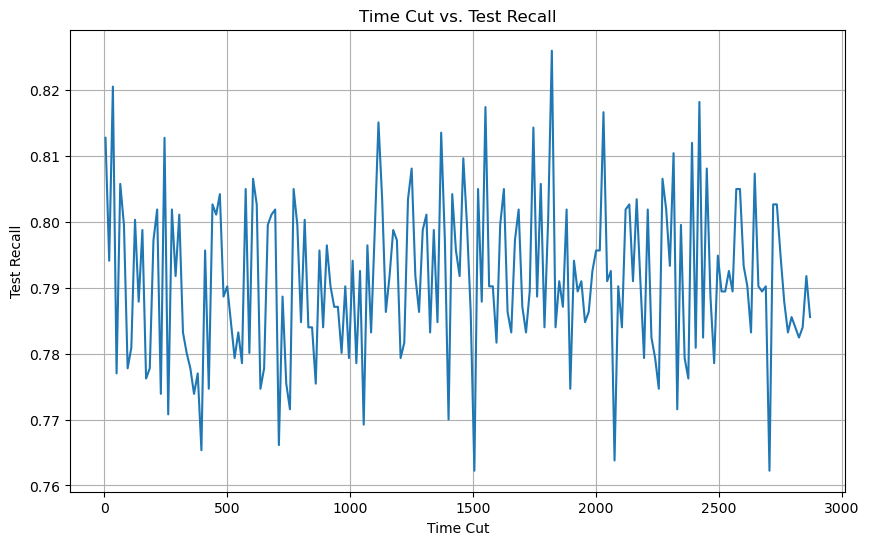

In [30]:
    # Ensure the metrics are numeric
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_recall'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_accuracy', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()

In [3]:
import mlflow

In [5]:
mlflow.search_experiments() 

Traceback (most recent call last):
  File "/home/azureuser/miniconda3/envs/mastering/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/azureuser/miniconda3/envs/mastering/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/azureuser/miniconda3/envs/mastering/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/azureuser/miniconda3/envs/mastering/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1334, in _

[]

In [1]:
import mlflow

# Get the experiment ID or name
experiment_name = "GAT Network 2024-09-05"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


Traceback (most recent call last):
  File "/home/azureuser/miniconda3/envs/mastering/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/azureuser/miniconda3/envs/mastering/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/azureuser/miniconda3/envs/mastering/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/azureuser/miniconda3/envs/mastering/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1334, in _

Experiment 'GAT Network 2024-09-05' not found.
